In [12]:
#common imports:
import numpy as np
import pandas as pd
from datetime import datetime
import os


#import for visualization
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
#for Worldmap
#import shapefile as shp


#for Modelling/timeseries:
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage import gaussian_filter


from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf


from pmdarima.arima import auto_arima
import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

#from wordcloud import WordCloud
from pandas_profiling import ProfileReport

sns.set(rc={'figure.figsize':(20,15)})


#suppress pandas future warnings:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

    

In [9]:
# load cleaned data time series:
df_time_m = pd.read_csv('timeseriesformodel.csv')

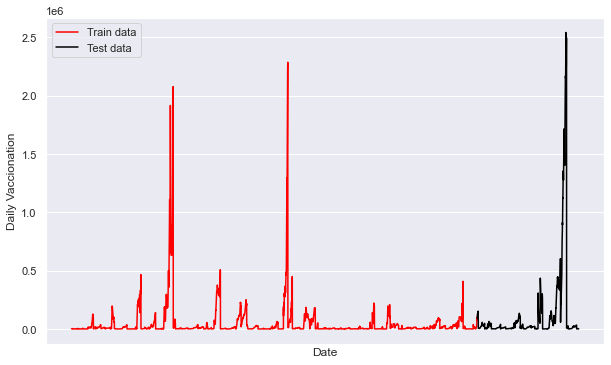

In [10]:
# Split data into train and test set
df_arima = df_time_m['daily_vaccinations']
train_test_split_ratio = int(len(df_arima)*0.8)
train_data, test_data = df_arima[:train_test_split_ratio], df_arima[train_test_split_ratio:]

# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Daily Vaccionation')
plt.xticks([])
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend();

## Simple Exponential Smoothing

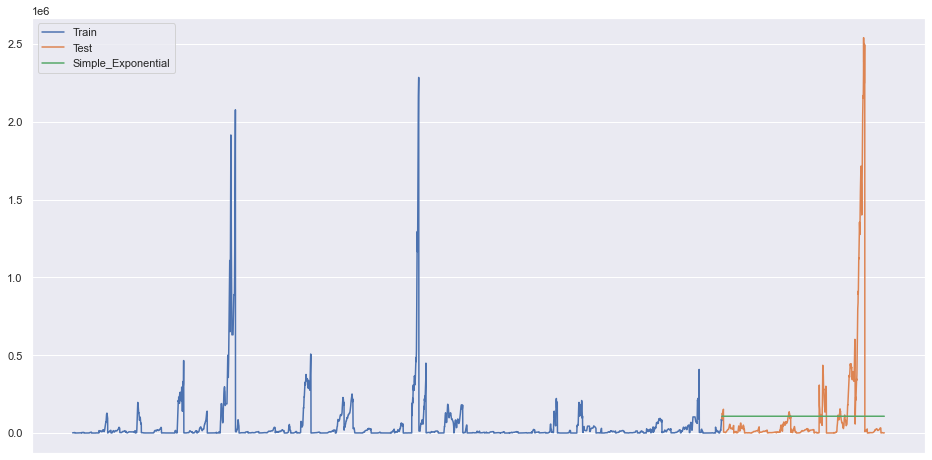

Simple Exponential Smoothing RMS :- 360897.876 & Smoothing Level :- 1.0


In [13]:
# Simple Exponential Smoothing Method
pred_values = test_data.copy()
pred_values = pd.DataFrame(pred_values)

simple_exponential_df = pd.DataFrame(columns = ['RMS','Smoothing Level'])

from itertools import permutations
perm = permutations(list(np.linspace(0.05,1,num=20)), 1)
for i in list(perm):
    fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = i[0])
    pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential)),3)
    simple_exponential_df = simple_exponential_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0]} , ignore_index=True)

opt_values = simple_exponential_df.loc[simple_exponential_df['RMS'] == min(simple_exponential_df['RMS']),['Smoothing Level']].values


# Use optimised values from the lists
fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0])
pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Simple_Exponential'], label='Simple_Exponential')
plt.xticks([])
plt.legend(loc='best')
plt.show()

rms_sim_exp = sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential))
print("Simple Exponential Smoothing RMS :- " + str(round(rms_sim_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)))

## Holt's Exponential Smoothing

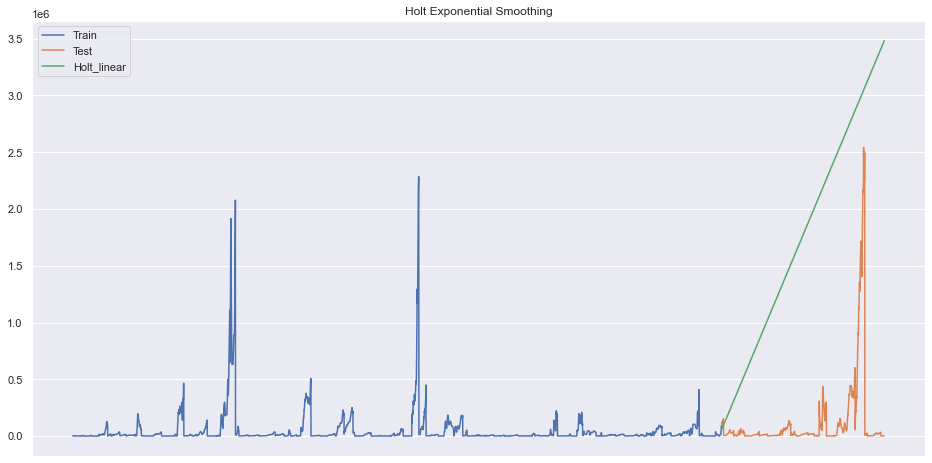

Holt’s Exponential Smoothing RMS :- 1896151.206 & Smoothing Level :- 0.1 & Smoothing Slope :- 0.05


In [14]:
# Holt's Exponential Smoothing Method
holt_linear_df = pd.DataFrame(columns = ['RMS','Smoothing Level','Smoothing Slope'])

perm = permutations(list(np.linspace(0.05,1,num=20)), 2)
for i in list(perm):
    fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_slope=i[1])
    pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

    rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear)),3)
    holt_linear_df = holt_linear_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0], 'Smoothing Slope':i[1]} , ignore_index=True)

opt_values = holt_linear_df.loc[holt_linear_df['RMS'] == min(holt_linear_df['RMS']),['Smoothing Level','Smoothing Slope']].values


# Using optimised values from the lists.
fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0],smoothing_slope=opt_values[0][1])
pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Holt_linear'], label='Holt_linear')
plt.xticks([])
plt.legend(loc='best')
plt.title('Holt Exponential Smoothing')
plt.show()

rms_holt_exp = sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear))
print("Holt’s Exponential Smoothing RMS :- " + str(round(rms_holt_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)) + " & Smoothing Slope :- "+str(round(opt_values[0][1],3)))

## Auto-Regressive Integrated Moving Average (ARIMA)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=152554.815, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=169163.906, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=152564.340, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=164831.486, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=152550.677, Time=0.76 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=152553.925, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=152549.186, Time=0.26 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=152547.690, Time=0.19 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=152549.590, Time=0.26 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=152551.122, Time=0.45 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=152537.321, Time=0.36 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=152544.426, Time=0.36 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=152539.294, Time=0.49 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=152539.765, Time=0.57 sec
 ARIM

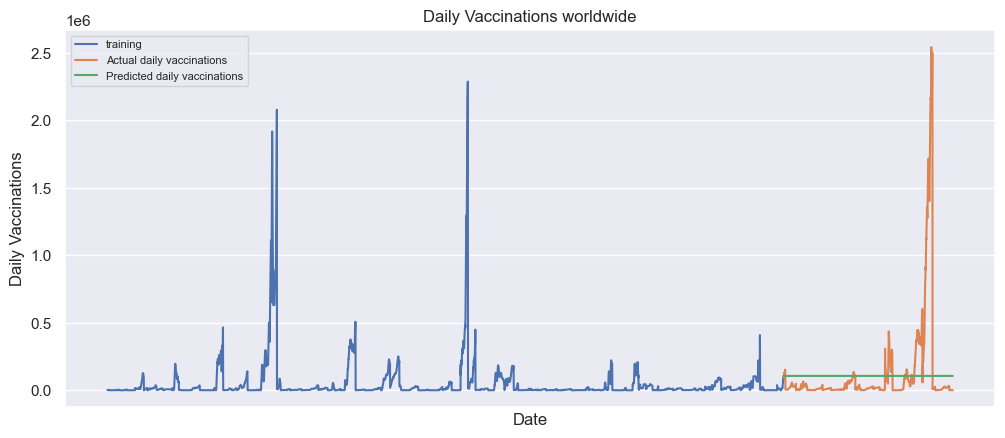

Auto-Arima RMSE :- 360964.969


In [15]:
# Auto ARIMA Method
arima_model = auto_arima(train_data,
                      start_p=1, start_q=1,
                      max_p=5, max_q=5,
                      test='adf',        
                      trace=True,
                      alpha=0.05,
                      scoring='mse',
                      suppress_warnings=True,
                      seasonal = False
                      )

# Fit the final model with the order
fitted_model = arima_model.fit(train_data) 
print(fitted_model.summary())

# Forecasting values
forecast_values = fitted_model.predict(len(test_data), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test_data.index)

# Plot the predicted stock price and original price
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='Actual daily vaccinations')
plt.plot(fcv_series,label='Predicted daily vaccinations')
plt.title('Daily Vaccinations worldwide')
plt.xlabel('Date')
plt.ylabel('Daily Vaccinations')
plt.xticks([])
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Evaluate the model by calculating RMSE
rms_auto_arima = sqrt(mean_squared_error(test_data.values, fcv_series))
print("Auto-Arima RMSE :- " + str(round(rms_auto_arima,3)))

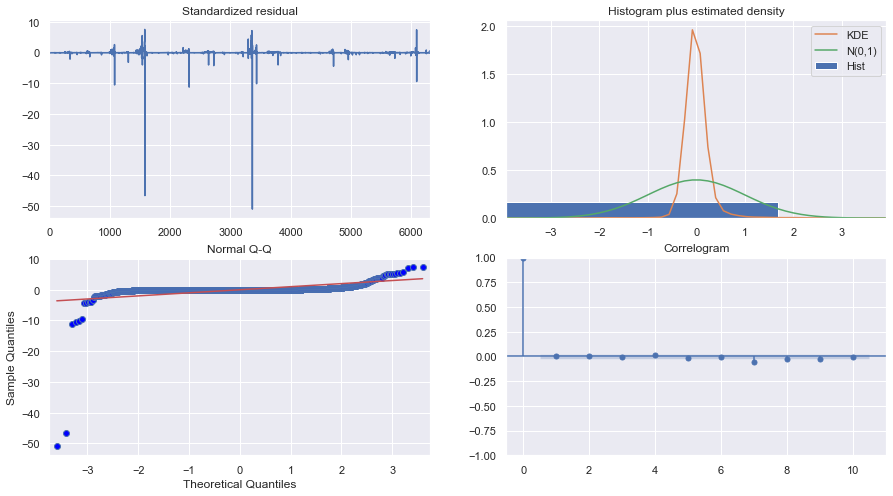

In [16]:
# Plotting diagnostics of the ARIMA model
arima_model.plot_diagnostics(figsize=(15,8))
plt.show()

Evaluation of the models
to evaluate the performance of the model, we will use Root Mean Squared Error (RMSE) and compare which model performed the best.

In [17]:
# Printing RMSE of all the methods
print("RMSE of all the methods")
print("Auto-Arima: ", round(rms_auto_arima,3))
print("Simple Exponential Smoothing: ", round(rms_sim_exp,3))
print("Holt’s Exponential Smoothing: ", round(rms_holt_exp,3))

RMSE of all the methods
Auto-Arima:  360964.969
Simple Exponential Smoothing:  360897.876
Holt’s Exponential Smoothing:  1896151.206


From the three models we trained the Simple Exponential Smoothing reached the smallest RSME. (Woran liegt das? Wir haben keinen Trend und keine seasonality und damit z.B. Holt's nicht geeignet?)